# **ENTRENAMIENTO DE MODELOS**

## **Bloque 0 – Instalación de librerías**

In [2]:
!pip install xgboost scikit-learn holidays joblib

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\USUARIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## **Bloque 1 – Imports, carga del dataset y filtro de peajes**

In [4]:
%pip install holidays

     ---------------------------------------- 0.0/50.0 kB ? eta -:--:--
     --------------- ---------------------- 20.5/50.0 kB 640.0 kB/s eta 0:00:01
     ------------------------------- ------ 41.0/50.0 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 50.0/50.0 kB 510.3 kB/s eta 0:00:00
   ---------------------------------------- 0.0/1.3 MB ? eta -:--:--
   ------- -------------------------------- 0.2/1.3 MB 7.6 MB/s eta 0:00:01
   ----------------- ---------------------- 0.6/1.3 MB 8.9 MB/s eta 0:00:01
   ---------------------------- ----------- 0.9/1.3 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------  1.3/1.3 MB 9.1 MB/s eta 0:00:01
   ---------------------------------------- 1.3/1.3 MB 8.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\USUARIO\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [16]:
import pandas as pd
import numpy as np
import holidays
from datetime import timedelta

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from joblib import dump
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os

# Ruta al CSV ya procesado (trafico_limpio.csv)
CSV_PATH = "./data/trafico_limpio.csv"  # cambia si lo tienes en otra ruta

df = pd.read_csv(CSV_PATH)

# Asegurar tipo fecha
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')

print(df.shape)
df.head()

(38833, 7)


,fecha,peaje,sentido_1,sentido_2,total,tipo_dia,trm_dolar
0,2022-01-01,AGUAS NEGRAS,2810,1786,4596,festivo,4082.75
1,2022-01-01,ZAMBITO,2561,1429,3990,festivo,4082.75
2,2022-01-01,SAN JUAN,937,1169,2106,festivo,4082.75
3,2022-01-01,SAN DIEGO,886,901,1787,festivo,4082.75
4,2022-01-01,SABOYA,2181,1375,3556,festivo,4082.75


In [6]:
# Lista de peajes target
peajes_target = [
    "PTO. TRIUNFO",
    "SACHICA",
    "CASABLANCA",
    "PEAJE TUNEL LA LINEA QUINDIO",
    "CERRITOS II",
    "PEAJE TUNEL LA LINEA TOLIMA",
    "BICENTENARIO",
    "LA PARADA",
]

# Filtrar solo estos peajes
df = df[df['peaje'].isin(peajes_target)].copy()

# Ordenar cronológicamente por peaje
df = df.sort_values(['peaje', 'fecha']).reset_index(drop=True)

df['peaje'].unique(), df.shape

(array(['BICENTENARIO', 'CASABLANCA', 'CERRITOS II', 'LA PARADA',
        'PEAJE TUNEL LA LINEA QUINDIO', 'PEAJE TUNEL LA LINEA TOLIMA',
        'PTO. TRIUNFO', 'SACHICA'], dtype=object),
 (9440, 7))

## **Bloque 2 – Recalcular tipo de día (opcional) y variables de calendario**

In [7]:
# Recalcular tipo de día usando festivos Colombia
years = range(df['fecha'].dt.year.min(), df['fecha'].dt.year.max() + 2)
co_holidays = holidays.country_holidays('CO', years=years)

def clasificar_dia(fecha):
    d = fecha.date()
    if d in co_holidays:
        return "festivo"
    elif fecha.weekday() >= 5:
        return "fin_de_semana"
    else:
        return "entre_semana"

df['tipo_dia'] = df['fecha'].apply(clasificar_dia)

# Variables de calendario
df['year'] = df['fecha'].dt.year
df['month'] = df['fecha'].dt.month
df['day'] = df['fecha'].dt.day
df['dayofweek'] = df['fecha'].dt.dayofweek
df['dayofyear'] = df['fecha'].dt.dayofyear

# Representaciones cíclicas
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * (df['month'] - 1) / 12)
df['month_cos'] = np.cos(2 * np.pi * (df['month'] - 1) / 12)

# One-hot de tipo_dia
df = pd.get_dummies(df, columns=['tipo_dia'], drop_first=False)

df.head()

,fecha,peaje,sentido_1,sentido_2,total,trm_dolar,year,month,day,dayofweek,dayofyear,dow_sin,dow_cos,month_sin,month_cos,tipo_dia_entre_semana,tipo_dia_festivo,tipo_dia_fin_de_semana
0,2022-11-01,BICENTENARIO,0,0,0,4898.74,2022,11,1,1,305,0.781831,0.623490,-0.866025,0.5,True,False,False
1,2022-11-02,BICENTENARIO,0,0,0,4975.58,2022,11,2,2,306,0.974928,-0.222521,-0.866025,0.5,True,False,False
2,2022-11-03,BICENTENARIO,0,0,0,5015.84,2022,11,3,3,307,0.433884,-0.900969,-0.866025,0.5,True,False,False
3,2022-11-04,BICENTENARIO,0,0,0,5058.02,2022,11,4,4,308,-0.433884,-0.900969,-0.866025,0.5,True,False,False
4,2022-11-05,BICENTENARIO,0,0,0,5061.21,2022,11,5,5,309,-0.974928,-0.222521,-0.866025,0.5,False,False,True


## **Bloque 3 – Funciones auxiliares (lags, rolling, métricas, trimming, split, slug)**

In [8]:
def add_lag_and_rolling_features(
    df,
    group_col='peaje',
    target_cols=('sentido_1', 'sentido_2'),
    lags=(1, 3, 7, 14, 21, 28),
    rolling_windows=(3, 7, 14, 28)
):
    df = df.copy()
    df = df.sort_values([group_col, 'fecha'])

    for target in target_cols:
        if target not in df.columns:
            continue

        # Lags
        for lag in lags:
            df[f'{target}_lag_{lag}'] = df.groupby(group_col)[target].shift(lag)

        # Medias móviles (shift 1 para no usar el día actual)
        for win in rolling_windows:
            df[f'{target}_rollmean_{win}'] = (
                df.groupby(group_col)[target]
                  .shift(1)
                  .rolling(win)
                  .mean()
            )
    return df


def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_pred - y_true)
    # evitar división por cero
    mask = denom != 0
    return np.mean(diff[mask] / denom[mask]) * 100 if np.any(mask) else np.nan


def mase(y_true, y_pred, y_train, seasonality=7):
    """
    y_true, y_pred: parte a evaluar (val o test)
    y_train: serie de entrenamiento (para el denominador)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_train = np.array(y_train)

    if len(y_train) <= seasonality:
        return np.nan

    naive_forecast = y_train[seasonality:] - y_train[:-seasonality]
    denom = np.mean(np.abs(naive_forecast))
    if denom == 0:
        return np.nan

    return np.mean(np.abs(y_true - y_pred)) / denom


def trim_zeros_begin_end(df_peaje, col='total'):
    """
    Recorta filas al inicio y al final donde col == 0 para ese peaje.
    Mantiene ceros internos si los hubiera.
    """
    arr = df_peaje[col].values
    non_zero_idx = np.where(arr != 0)[0]
    if len(non_zero_idx) == 0:
        return df_peaje.iloc[0:0].copy()  # vacío
    start_i = non_zero_idx[0]
    end_i = non_zero_idx[-1]
    return df_peaje.iloc[start_i:end_i+1].copy()


def time_series_split_train_val_test(df_peaje, test_days=30, val_days=90):
    """
    Split cronológico:
    - test: últimos `test_days`
    - validation: `val_days` anteriores a test (o menos si no hay tantos datos)
    - train: el resto.
    Si no hay suficientes datos, se reduce validation.
    """
    df_peaje = df_peaje.sort_values('fecha').reset_index(drop=True)
    n = len(df_peaje)
    if n <= test_days + 10:
        # muy pocos datos, reducimos test y val proporcionalmente
        test_days = min(10, n // 3)
        val_days = min(30, max(0, n - test_days - 10))

    test_size = min(test_days, n)
    val_size = min(val_days, max(0, n - test_size))

    test_start = n - test_size
    val_start = max(0, n - test_size - val_size)

    train = df_peaje.iloc[:val_start].copy()
    val = df_peaje.iloc[val_start:test_start].copy()
    test = df_peaje.iloc[test_start:].copy()

    return train, val, test


import re
import unicodedata

def slugify(s):
    s = str(s)
    s = unicodedata.normalize('NFKD', s).encode('ascii', 'ignore').decode('ascii')
    s = re.sub(r'[^a-zA-Z0-9]+', '_', s)
    s = s.strip('_').lower()
    return s

## **Bloque 4 – Añadir lags/rolling y limpiar NaNs**

In [9]:
# Crear lags y medias móviles por peaje
df_feat = add_lag_and_rolling_features(
    df,
    group_col='peaje',
    target_cols=('sentido_1', 'sentido_2'),
    lags=(1, 3, 7, 14, 21, 28),
    rolling_windows=(3, 7, 14, 28)
)

# Después de crear lags/rolling, habrá NaNs al inicio de cada serie.
# Los eliminamos por peaje para evitar problemas.
def drop_na_per_peaje(df_in, group_col='peaje'):
    dfs = []
    for g, dfg in df_in.groupby(group_col):
        dfg = dfg.dropna().reset_index(drop=True)
        dfs.append(dfg)
    return pd.concat(dfs, axis=0).reset_index(drop=True)

df_feat = drop_na_per_peaje(df_feat, group_col='peaje')
df_feat.head()

,fecha,peaje,sentido_1,sentido_2,total,trm_dolar,year,month,day,dayofweek,...,sentido_2_lag_1,sentido_2_lag_3,sentido_2_lag_7,sentido_2_lag_14,sentido_2_lag_21,sentido_2_lag_28,sentido_2_rollmean_3,sentido_2_rollmean_7,sentido_2_rollmean_14,sentido_2_rollmean_28
0,2022-11-29,BICENTENARIO,813,747,1560,4840.60,2022,11,29,1,...,726.0,0.0,0.0,0.0,0.0,0.0,242.000000,103.714286,51.857143,25.928571
1,2022-11-30,BICENTENARIO,1005,992,1997,4809.51,2022,11,30,2,...,747.0,0.0,0.0,0.0,0.0,0.0,491.000000,210.428571,105.214286,52.607143
2,2022-12-01,BICENTENARIO,1083,1009,2092,4815.59,2022,12,1,3,...,992.0,726.0,0.0,0.0,0.0,0.0,821.666667,352.142857,176.071429,88.035714
3,2022-12-02,BICENTENARIO,1218,1047,2265,4779.06,2022,12,2,4,...,1009.0,747.0,0.0,0.0,0.0,0.0,916.000000,496.285714,248.142857,124.071429
4,2022-12-03,BICENTENARIO,1095,946,2041,4767.19,2022,12,3,5,...,1047.0,992.0,0.0,0.0,0.0,0.0,1016.000000,645.857143,322.928571,161.464286


## **Bloque 5 – Función de entrenamiento con búsqueda de hiperparámetros y métricas**

In [10]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Función RMSE compatible con cualquier versión de sklearn
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def train_xgb_with_tuning(df_peaje, target_col, use_gpu=True):
    """
    Entrena XGBoost para un peaje y un sentido específico:
    - Recorta ceros al inicio/fin según 'total'.
    - Split train/val/test cronológico.
    - Búsqueda de hiperparámetros sobre un conjunto de candidatos.
    - Compatible con versiones antiguas de xgboost y sklearn.
    """
    # Recorte de ceros inicio/fin según total
    df_peaje = trim_zeros_begin_end(df_peaje, col='total')
    df_peaje = df_peaje.sort_values('fecha').reset_index(drop=True)

    # Si no hay variación
    if target_col not in df_peaje.columns or df_peaje[target_col].nunique() <= 1:
        print(f"[{df_peaje['peaje'].iloc[0]} - {target_col}] Sin variación suficiente, se omite.")
        return None

    # Split temporal
    train_df, val_df, test_df = time_series_split_train_val_test(
        df_peaje, test_days=30, val_days=90
    )

    # Features: excluir columnas que causan leakage
    exclude_cols = ['fecha', 'peaje', 'sentido_1', 'sentido_2', 'total']
    feature_cols = [c for c in df_peaje.columns if c not in exclude_cols]

    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_val   = val_df[feature_cols]
    y_val   = val_df[target_col]
    X_test  = test_df[feature_cols]
    y_test  = test_df[target_col]

    # Tu versión no soporta GPU → usar siempre 'hist'
    tree_method = "hist"

    # Espacio de hiperparámetros
    param_grid = [
        {"max_depth": 3, "learning_rate": 0.05, "n_estimators": 600,
         "subsample": 0.9, "colsample_bytree": 0.9, "min_child_weight": 1, "gamma": 0.0},

        {"max_depth": 4, "learning_rate": 0.05, "n_estimators": 800,
         "subsample": 0.9, "colsample_bytree": 0.9, "min_child_weight": 5, "gamma": 0.0},

        {"max_depth": 5, "learning_rate": 0.03, "n_estimators": 1000,
         "subsample": 0.8, "colsample_bytree": 0.8, "min_child_weight": 3, "gamma": 0.1},

        {"max_depth": 6, "learning_rate": 0.03, "n_estimators": 1200,
         "subsample": 0.8, "colsample_bytree": 0.8, "min_child_weight": 5, "gamma": 0.1},

        {"max_depth": 4, "learning_rate": 0.1, "n_estimators": 500,
         "subsample": 0.8, "colsample_bytree": 0.8, "min_child_weight": 1, "gamma": 0.0},
    ]

    best_model = None
    best_rmse_val = np.inf
    best_params = None

    # BÚSQUEDA MANUAL DE HIPERPARÁMETROS (SIN early stopping)
    for params in param_grid:
        model = XGBRegressor(
            objective="reg:squarederror",
            tree_method=tree_method,
            random_state=42,
            **params
        )

        model.fit(X_train, y_train)  # sin eval_set, sin callbacks

        # Métrica VALIDACIÓN
        y_val_pred = model.predict(X_val)
        rmse_val = rmse(y_val, y_val_pred)

        if rmse_val < best_rmse_val:
            best_rmse_val = rmse_val
            best_model = model
            best_params = params

    print(f"Mejores hiperparámetros para {df_peaje['peaje'].iloc[0]} - {target_col}: {best_params}")
    print(f"RMSE validación = {best_rmse_val:.2f}")

    # Usamos el mejor modelo encontrado
    final_model = best_model

    # Predicciones en TRAIN / VAL / TEST
    y_train_pred = final_model.predict(X_train)
    y_val_pred   = final_model.predict(X_val)
    y_test_pred  = final_model.predict(X_test)

    # Métricas
    rmse_train = rmse(y_train, y_train_pred)
    rmse_val   = rmse(y_val, y_val_pred)
    rmse_test  = rmse(y_test, y_test_pred)

    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_val   = mean_absolute_error(y_val, y_val_pred)
    mae_test  = mean_absolute_error(y_test, y_test_pred)

    smape_val = smape(y_val, y_val_pred)
    smape_test = smape(y_test, y_test_pred)

    y_trainval = pd.concat([y_train, y_val]).values
    mase_val = mase(y_val, y_val_pred, y_trainval, seasonality=7)
    mase_test = mase(y_test, y_test_pred, y_trainval, seasonality=7)

    metrics = {
        "rmse_train": rmse_train,
        "mae_train": mae_train,
        "rmse_val": rmse_val,
        "mae_val": mae_val,
        "rmse_test": rmse_test,
        "mae_test": mae_test,
        "smape_val": smape_val,
        "smape_test": smape_test,
        "mase_val": mase_val,
        "mase_test": mase_test,
        "best_params": best_params,
    }

    splits = {
        "train": train_df,
        "val": val_df,
        "test": test_df,
        "y_train_pred": y_train_pred,
        "y_val_pred": y_val_pred,
        "y_test_pred": y_test_pred,
        "feature_cols": feature_cols,
    }

    return final_model, metrics, splits

## **Bloque 6 – Función para pronosticar 30 días extra y construir DataFrame completo + gráfico**

In [11]:
def get_tipo_dia_from_date(fecha):
    d = fecha.date()
    if d in co_holidays:
        return "festivo"
    elif fecha.weekday() >= 5:
        return "fin_de_semana"
    else:
        return "entre_semana"


def build_features_for_future_row(last_known_row, new_date):
    """
    Construye features de calendario y tipo_dia dummies a partir de la última fila conocida.
    TRM (u otras exógenas) se mantienen igual al último valor disponible.
    """
    row = last_known_row.copy()
    row['fecha'] = new_date
    row['year'] = new_date.year
    row['month'] = new_date.month
    row['day'] = new_date.day
    row['dayofweek'] = new_date.dayofweek
    row['dayofyear'] = new_date.timetuple().tm_yday
    row['dow_sin'] = np.sin(2 * np.pi * row['dayofweek'] / 7)
    row['dow_cos'] = np.cos(2 * np.pi * row['dayofweek'] / 7)
    row['month_sin'] = np.sin(2 * np.pi * (row['month'] - 1) / 12)
    row['month_cos'] = np.cos(2 * np.pi * (row['month'] - 1) / 12)

    tipo = get_tipo_dia_from_date(new_date)
    for col in ['tipo_dia_entre_semana', 'tipo_dia_fin_de_semana', 'tipo_dia_festivo']:
        if col not in row:
            row[col] = 0
    row['tipo_dia_entre_semana'] = 1 if tipo == "entre_semana" else 0
    row['tipo_dia_fin_de_semana'] = 1 if tipo == "fin_de_semana" else 0
    row['tipo_dia_festivo'] = 1 if tipo == "festivo" else 0

    # TRM y otras exógenas: mantenemos el último valor
    # (ya vienen en last_known_row, no las tocamos)

    return row


def forecast_future_days(df_peaje_full, model, target_col, feature_cols, horizon=30):
    """
    Pronostica 'horizon' días hacia adelante de forma recursiva
    usando el modelo y recalculando lags/rolling con cada nueva predicción.
    """
    history = df_peaje_full.sort_values('fecha').copy()
    history = history.reset_index(drop=True)

    future_rows = []

    last_date = history['fecha'].max()
    for step in range(horizon):
        new_date = last_date + timedelta(days=1)
        last_date = new_date

        # Tomamos la última fila de history como base para exógenas
        base_row = history.iloc[-1].copy()
        new_row = build_features_for_future_row(base_row, new_date)

        # Recalcular lags y rolling para el target específico
        # 1) añadimos temporalmente la nueva fila sin target
        temp = pd.concat([history, pd.DataFrame([new_row])], axis=0).reset_index(drop=True)

        # 2) volvemos a calcular lags/rolling SOLO para el peaje en cuestión
        temp = add_lag_and_rolling_features(
            temp,
            group_col='peaje',
            target_cols=(target_col,),
            lags=(1, 3, 7, 14, 21, 28),
            rolling_windows=(3, 7, 14, 28)
        )

        new_row_full = temp.iloc[-1].copy()

        # Si aún hay NaNs en lags/rolling (al principio), los podemos rellenar con 0
        new_row_full = new_row_full.fillna(0)

        X_new = new_row_full[feature_cols].values.reshape(1, -1)
        y_new_pred = model.predict(X_new)[0]

        new_row_full[target_col] = y_new_pred

        history = temp.copy()
        future_rows.append(new_row_full)

    future_df = pd.DataFrame(future_rows)
    return future_df


def build_full_results_df(df_peaje, target_col, splits, future_df, metrics, model_name):
    """
    Construye un DataFrame unificado con:
    - train/val/test/future
    - y_real, y_pred
    - métricas
    """
    train_df = splits["train"].copy()
    val_df = splits["val"].copy()
    test_df = splits["test"].copy()

    y_train_pred = splits["y_train_pred"]
    y_val_pred = splits["y_val_pred"]
    y_test_pred = splits["y_test_pred"]

    train_df['set'] = 'train'
    val_df['set'] = 'val'
    test_df['set'] = 'test'

    train_df['y_real'] = train_df[target_col]
    val_df['y_real'] = val_df[target_col]
    test_df['y_real'] = test_df[target_col]

    train_df['y_pred'] = y_train_pred
    val_df['y_pred'] = y_val_pred
    test_df['y_pred'] = y_test_pred

    # Future: solo predicciones, no hay y_real
    future_df = future_df.copy()
    future_df['set'] = 'future'
    future_df['y_real'] = np.nan
    future_df['y_pred'] = future_df[target_col]

    full = pd.concat([train_df, val_df, test_df, future_df], axis=0, ignore_index=True)
    full = full.sort_values('fecha').reset_index(drop=True)

    full['modelo'] = model_name
    full['target'] = target_col

    # Añadimos métricas como columnas (repetidas, pero simples de consumir luego)
    for k, v in metrics.items():
        full[k] = v

    return full


def plot_results(full_df, peaje, target_col):
    """
    Grafica:
    - Serie completa real (train+val+test)
    - Predicciones en test (últimos 30 días reales)
    - Predicciones en los 30 días futuros
    """
    full_df = full_df.sort_values('fecha')

    fig, ax = plt.subplots(figsize=(14, 5))

    # Serie real
    real_mask = full_df['set'].isin(['train', 'val', 'test'])
    ax.plot(full_df.loc[real_mask, 'fecha'],
            full_df.loc[real_mask, 'y_real'],
            label='Real')

    # Predicciones test
    test_mask = full_df['set'] == 'test'
    ax.plot(full_df.loc[test_mask, 'fecha'],
            full_df.loc[test_mask, 'y_pred'],
            linestyle='--',
            label='Predicción test')

    # Predicciones futuro
    future_mask = full_df['set'] == 'future'
    ax.plot(full_df.loc[future_mask, 'fecha'],
            full_df.loc[future_mask, 'y_pred'],
            linestyle=':',
            label='Predicción 30 días futuros')

    ax.set_title(f"{peaje} - {target_col}")
    ax.set_xlabel("Fecha")
    ax.set_ylabel("Tráfico")
    ax.legend()
    plt.tight_layout()
    plt.show()

## **Bloque 7 – Entrenar todos los modelos (por peaje y por sentido), guardar modelos y CSVs**

In [12]:
def generate_dashboard_html(df_hist, df_future, preds, idx_test, peaje, output_dir="./dashboards"):

    fig = go.Figure()

    # Línea histórica
    fig.add_trace(go.Scatter(
        x=df_hist.index,
        y=df_hist["total"],
        name="Histórico",
        mode="lines"
    ))

    # Línea predicciones test
    fig.add_trace(go.Scatter(
        x=idx_test,
        y=preds,
        name="Predicción Test",
        mode="lines"
    ))

    # Línea predicción a futuro
    future_dates = df_future.index[len(df_hist):]
    future_vals = df_future["total"].iloc[len(df_hist):]

    fig.add_trace(go.Scatter(
        x=future_dates,
        y=future_vals,
        name="Predicción Futura",
        mode="lines",
        line=dict(dash="dot")
    ))

    # Título y ejes
    fig.update_layout(
        title=f"Predicción de Tráfico - Peaje {peaje}",
        xaxis_title="Fecha",
        yaxis_title="Flujo Vehicular",
        template="plotly_white"
    )


    html_path = f"{output_dir}/dashboard_{peaje.replace(' ', '_')}.html"
    fig.write_html(html_path)

Peajes a modelar: ['BICENTENARIO' 'CASABLANCA' 'CERRITOS II' 'LA PARADA'
 'PEAJE TUNEL LA LINEA QUINDIO' 'PEAJE TUNEL LA LINEA TOLIMA'
 'PTO. TRIUNFO' 'SACHICA']

===== Entrenando modelo para BICENTENARIO - sentido_1 =====
Mejores hiperparámetros para BICENTENARIO - sentido_1: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'gamma': 0.0}
RMSE validación = 169.63
Modelo guardado en: ./modelo/xgb_bicentenario_sentido_1.joblib
Resultados detallados guardados en: ./modelo/resultados_bicentenario_sentido_1.csv


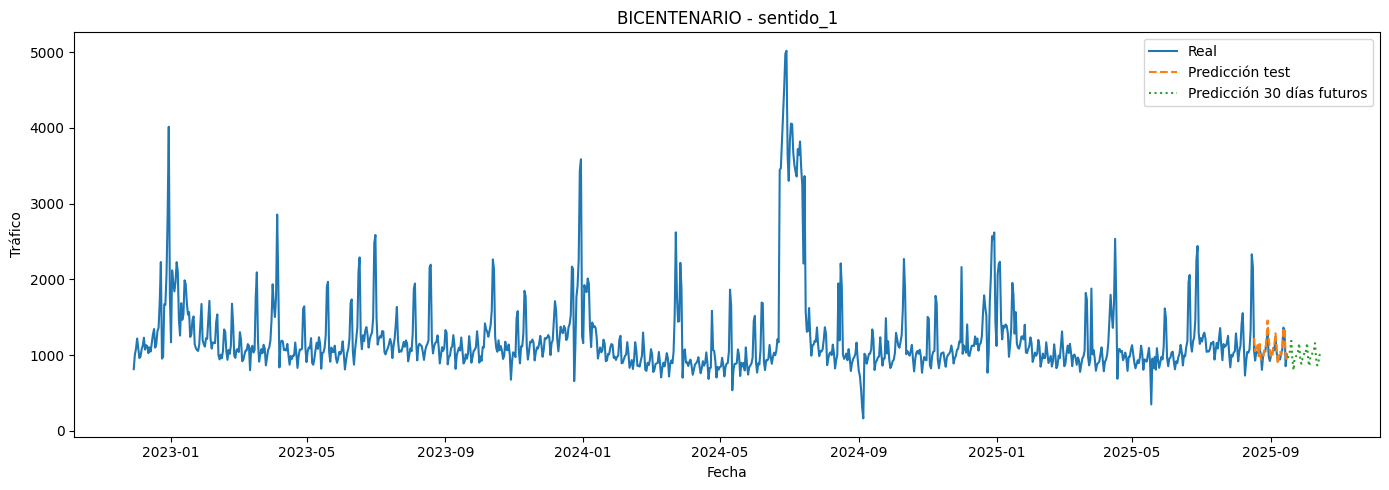


===== Entrenando modelo para BICENTENARIO - sentido_2 =====
Mejores hiperparámetros para BICENTENARIO - sentido_2: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 144.10
Modelo guardado en: ./modelo/xgb_bicentenario_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_bicentenario_sentido_2.csv


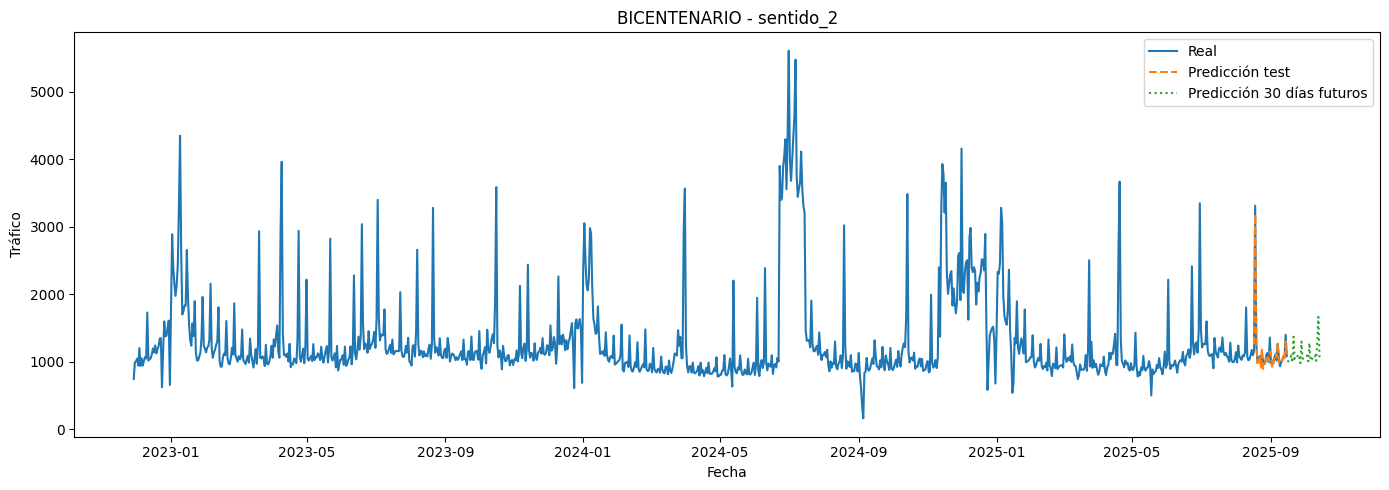


===== Entrenando modelo para CASABLANCA - sentido_1 =====
Mejores hiperparámetros para CASABLANCA - sentido_1: {'max_depth': 6, 'learning_rate': 0.03, 'n_estimators': 1200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.1}
RMSE validación = 465.60
Modelo guardado en: ./modelo/xgb_casablanca_sentido_1.joblib
Resultados detallados guardados en: ./modelo/resultados_casablanca_sentido_1.csv


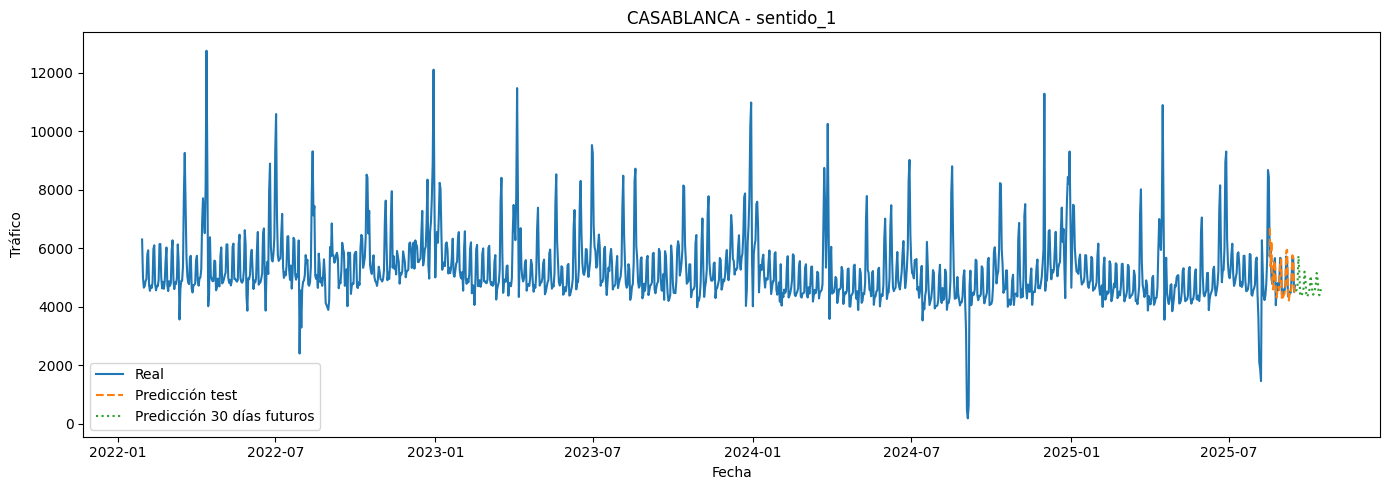


===== Entrenando modelo para CASABLANCA - sentido_2 =====
Mejores hiperparámetros para CASABLANCA - sentido_2: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 384.25
Modelo guardado en: ./modelo/xgb_casablanca_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_casablanca_sentido_2.csv


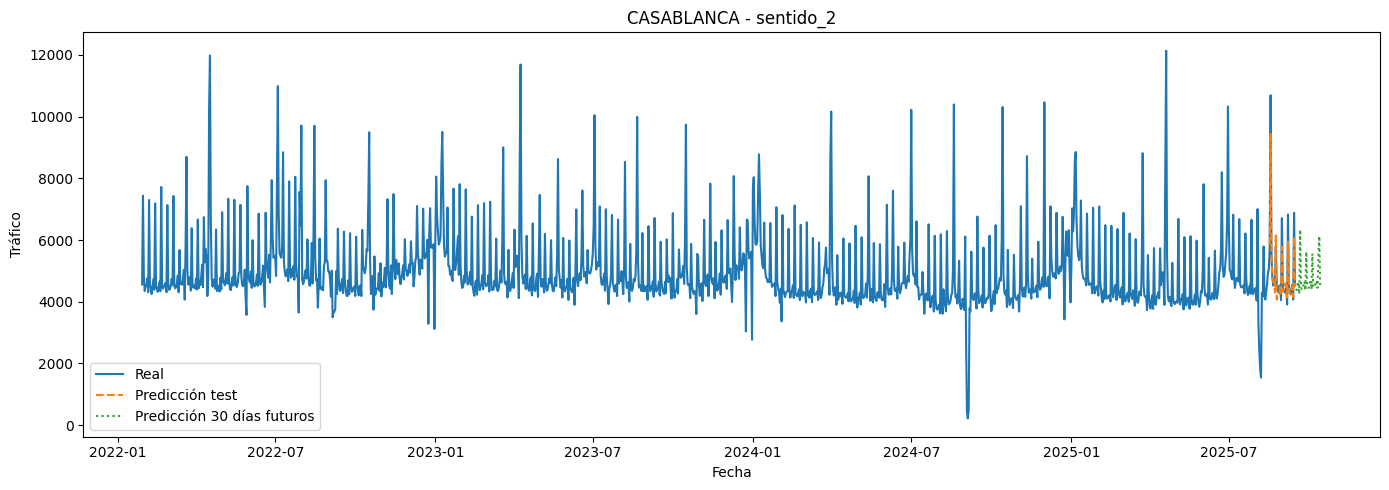


===== Entrenando modelo para CERRITOS II - sentido_1 =====
Mejores hiperparámetros para CERRITOS II - sentido_1: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 446.04
Modelo guardado en: ./modelo/xgb_cerritos_ii_sentido_1.joblib
Resultados detallados guardados en: ./modelo/resultados_cerritos_ii_sentido_1.csv


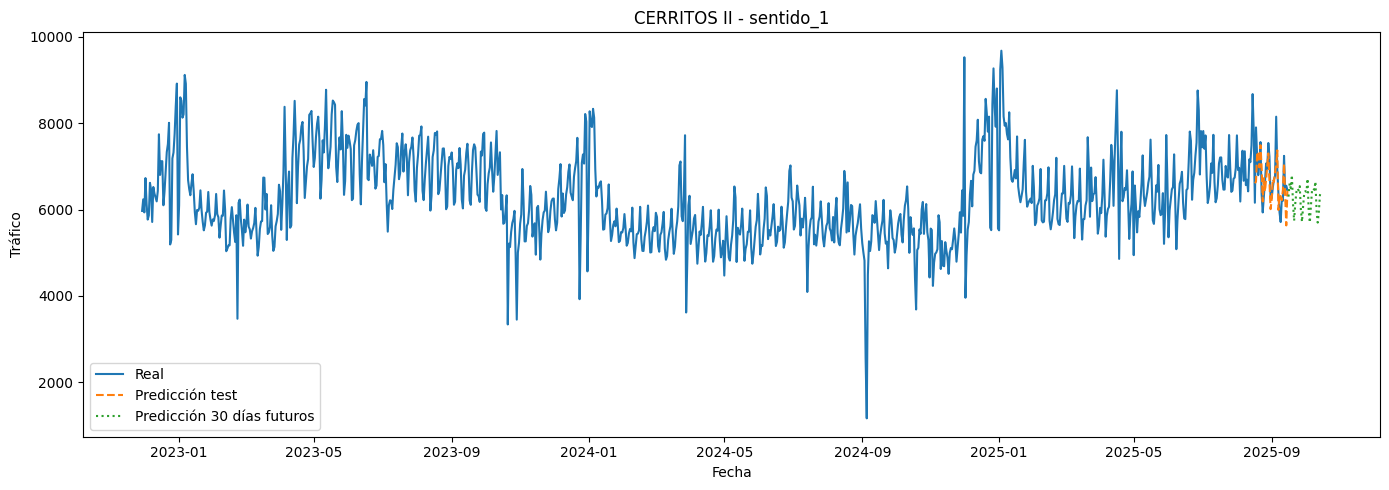


===== Entrenando modelo para CERRITOS II - sentido_2 =====
Mejores hiperparámetros para CERRITOS II - sentido_2: {'max_depth': 6, 'learning_rate': 0.03, 'n_estimators': 1200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.1}
RMSE validación = 278.24
Modelo guardado en: ./modelo/xgb_cerritos_ii_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_cerritos_ii_sentido_2.csv


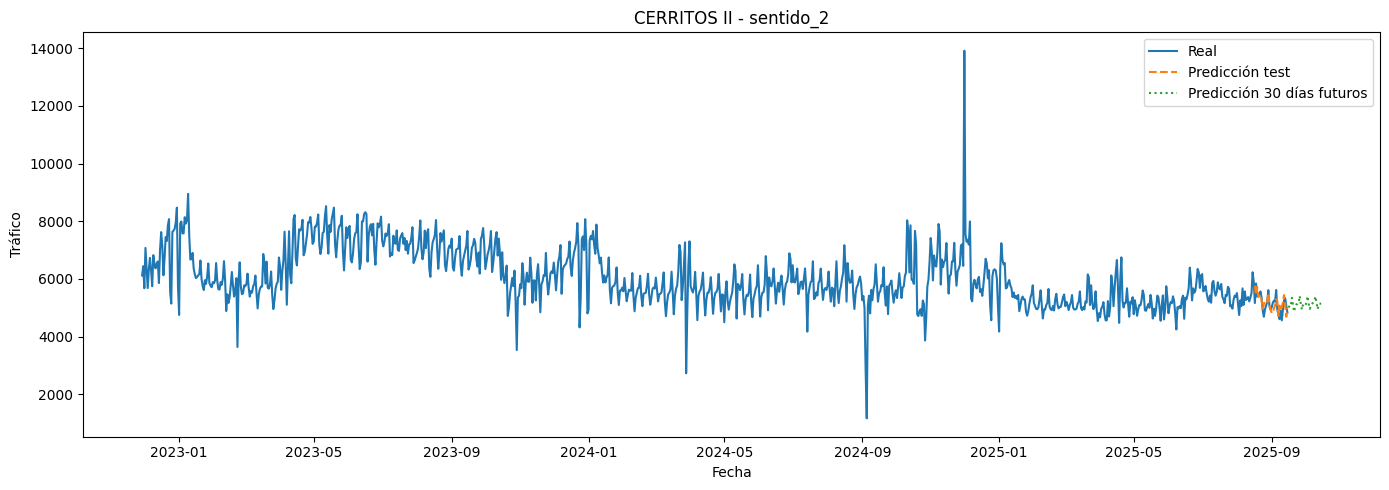


===== Entrenando modelo para LA PARADA - sentido_1 =====
[LA PARADA - sentido_1] Sin variación suficiente, se omite.

===== Entrenando modelo para LA PARADA - sentido_2 =====
Mejores hiperparámetros para LA PARADA - sentido_2: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 2767.96
Modelo guardado en: ./modelo/xgb_la_parada_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_la_parada_sentido_2.csv


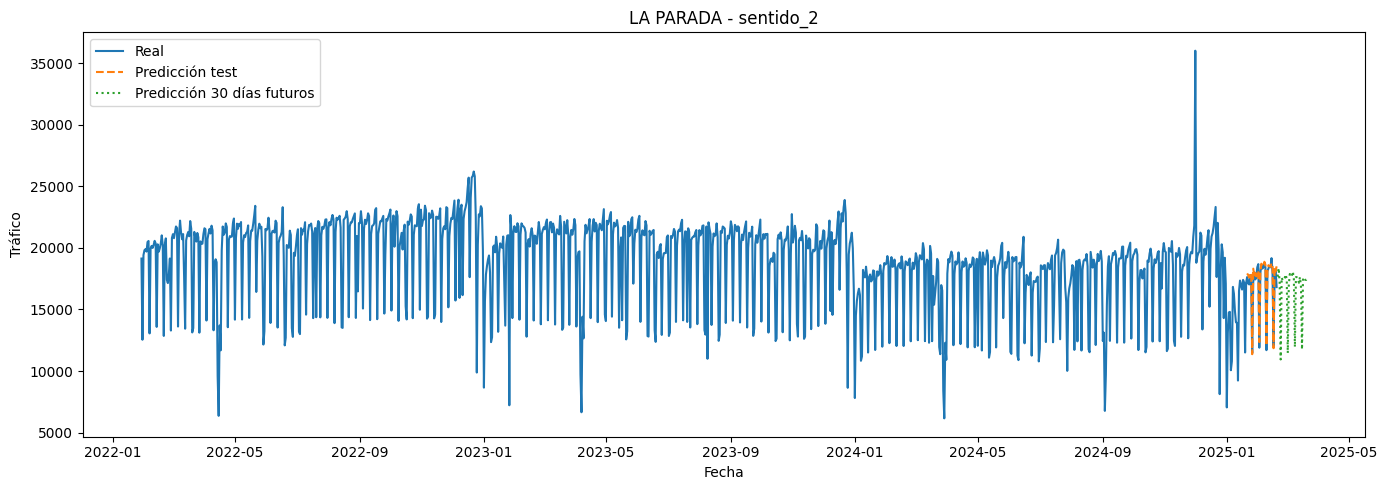


===== Entrenando modelo para PEAJE TUNEL LA LINEA QUINDIO - sentido_1 =====
[PEAJE TUNEL LA LINEA QUINDIO - sentido_1] Sin variación suficiente, se omite.

===== Entrenando modelo para PEAJE TUNEL LA LINEA QUINDIO - sentido_2 =====
Mejores hiperparámetros para PEAJE TUNEL LA LINEA QUINDIO - sentido_2: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 500, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 438.91
Modelo guardado en: ./modelo/xgb_peaje_tunel_la_linea_quindio_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_peaje_tunel_la_linea_quindio_sentido_2.csv


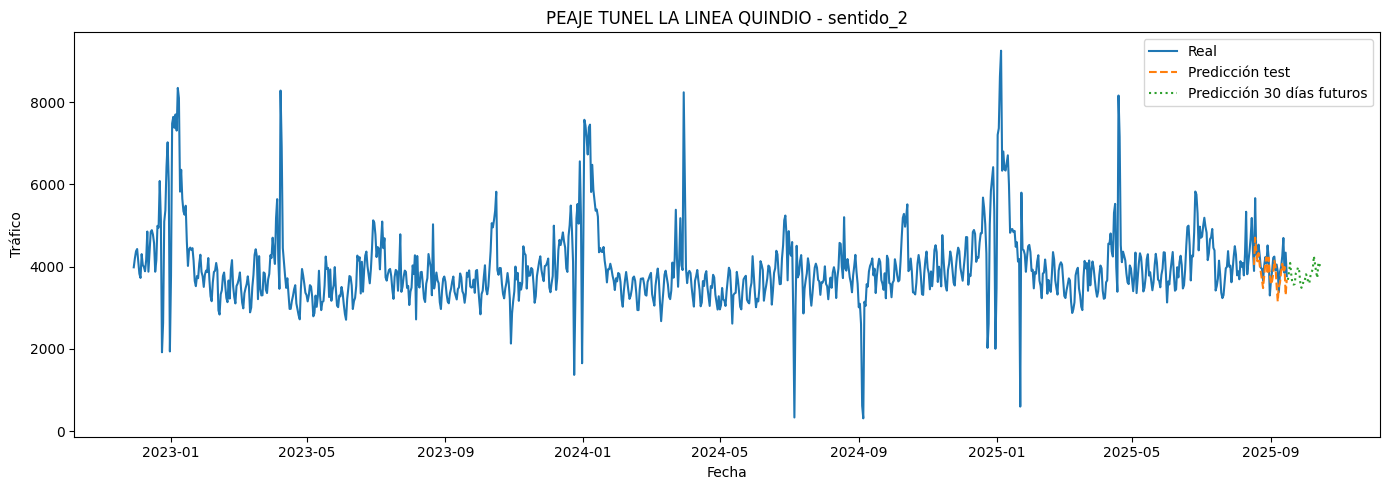


===== Entrenando modelo para PEAJE TUNEL LA LINEA TOLIMA - sentido_1 =====
Mejores hiperparámetros para PEAJE TUNEL LA LINEA TOLIMA - sentido_1: {'max_depth': 6, 'learning_rate': 0.03, 'n_estimators': 1200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.1}
RMSE validación = 373.16
Modelo guardado en: ./modelo/xgb_peaje_tunel_la_linea_tolima_sentido_1.joblib
Resultados detallados guardados en: ./modelo/resultados_peaje_tunel_la_linea_tolima_sentido_1.csv


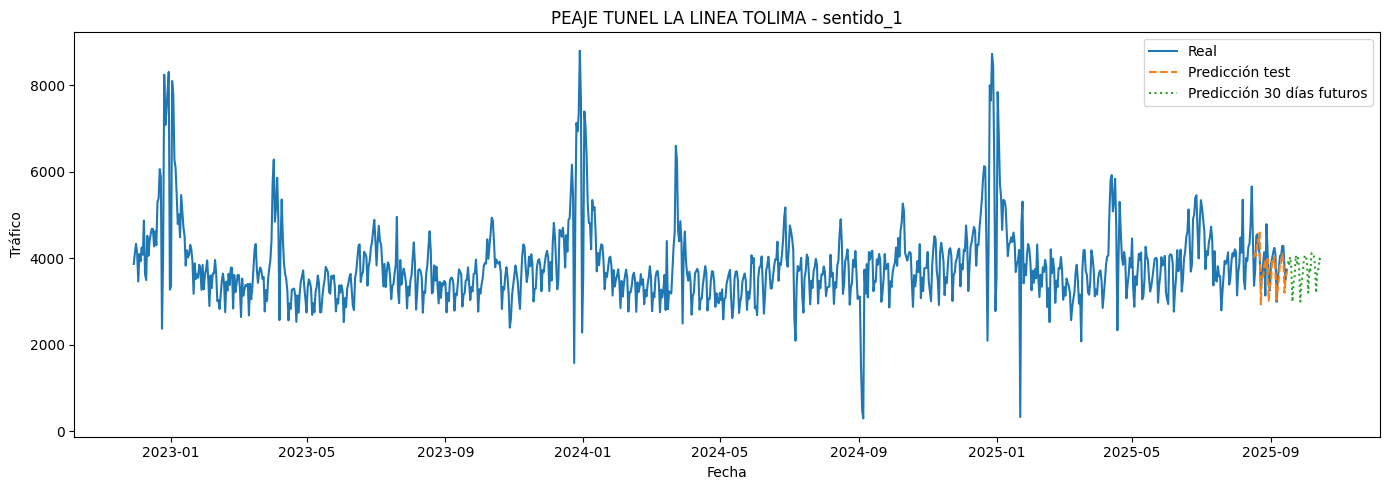


===== Entrenando modelo para PEAJE TUNEL LA LINEA TOLIMA - sentido_2 =====
[PEAJE TUNEL LA LINEA TOLIMA - sentido_2] Sin variación suficiente, se omite.

===== Entrenando modelo para PTO. TRIUNFO - sentido_1 =====
Mejores hiperparámetros para PTO. TRIUNFO - sentido_1: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 800, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'gamma': 0.0}
RMSE validación = 494.35
Modelo guardado en: ./modelo/xgb_pto_triunfo_sentido_1.joblib
Resultados detallados guardados en: ./modelo/resultados_pto_triunfo_sentido_1.csv


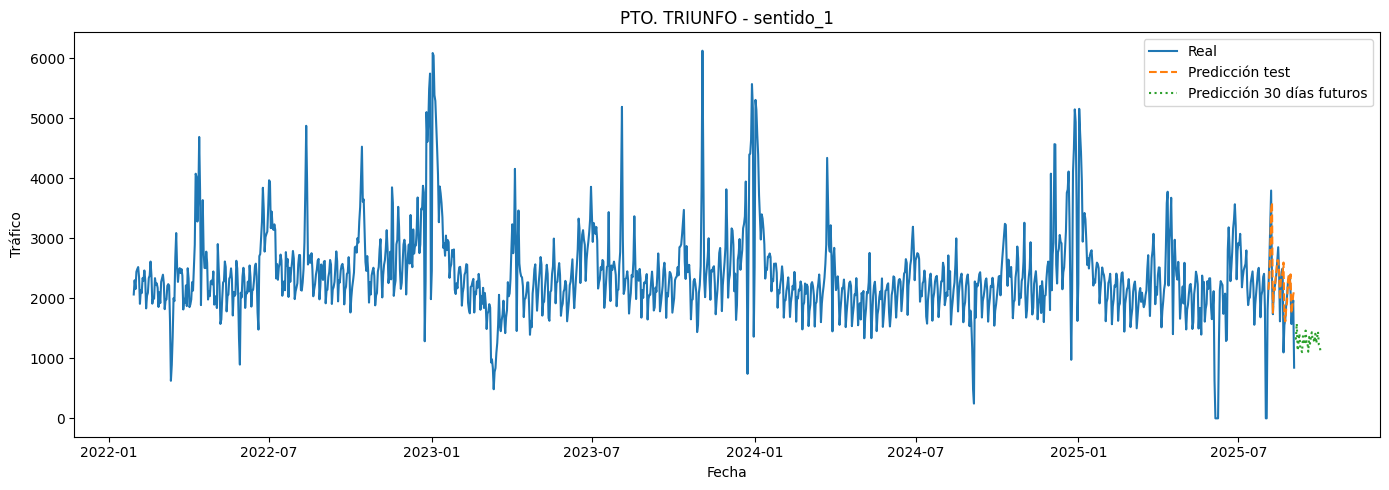


===== Entrenando modelo para PTO. TRIUNFO - sentido_2 =====
Mejores hiperparámetros para PTO. TRIUNFO - sentido_2: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 600, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'gamma': 0.0}
RMSE validación = 457.10
Modelo guardado en: ./modelo/xgb_pto_triunfo_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_pto_triunfo_sentido_2.csv


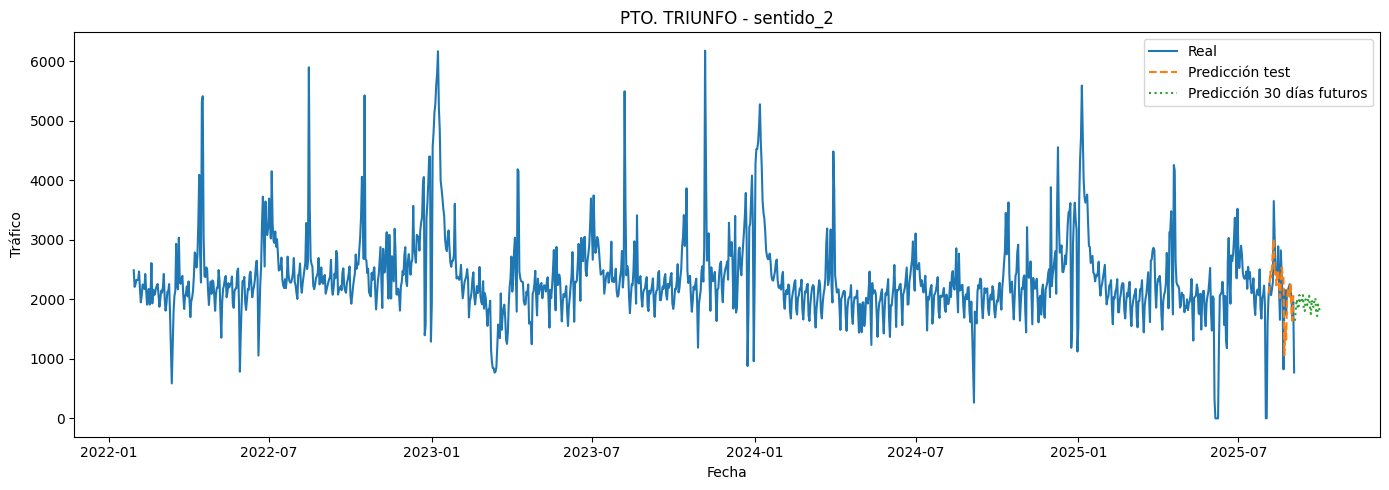


===== Entrenando modelo para SACHICA - sentido_1 =====
Mejores hiperparámetros para SACHICA - sentido_1: {'max_depth': 6, 'learning_rate': 0.03, 'n_estimators': 1200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.1}
RMSE validación = 260.08
Modelo guardado en: ./modelo/xgb_sachica_sentido_1.joblib
Resultados detallados guardados en: ./modelo/resultados_sachica_sentido_1.csv


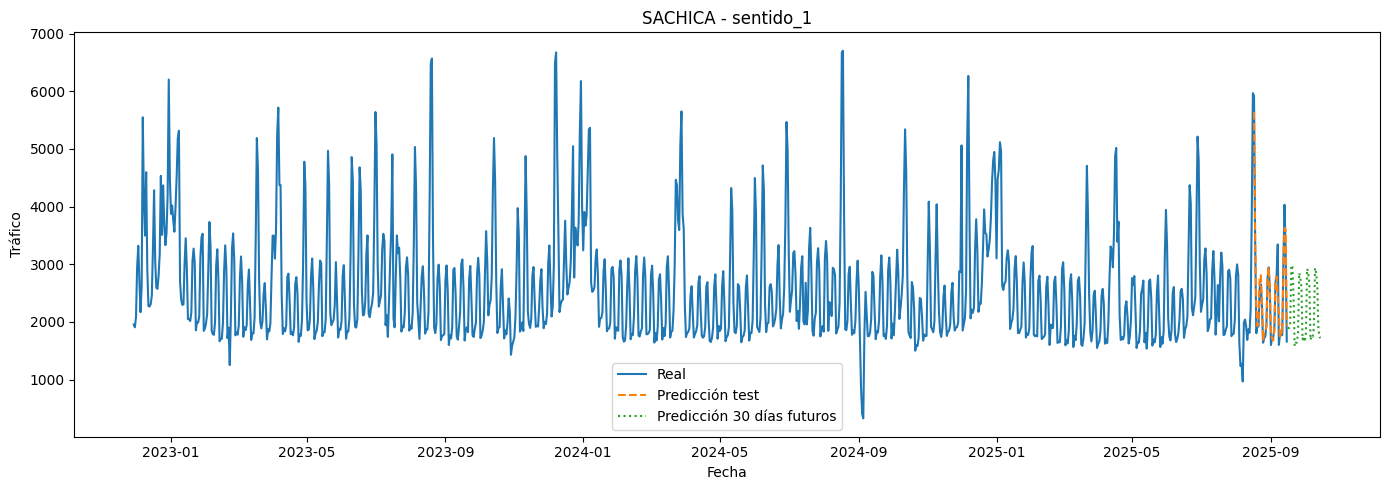


===== Entrenando modelo para SACHICA - sentido_2 =====
Mejores hiperparámetros para SACHICA - sentido_2: {'max_depth': 6, 'learning_rate': 0.03, 'n_estimators': 1200, 'subsample': 0.8, 'colsample_bytree': 0.8, 'min_child_weight': 5, 'gamma': 0.1}
RMSE validación = 214.03
Modelo guardado en: ./modelo/xgb_sachica_sentido_2.joblib
Resultados detallados guardados en: ./modelo/resultados_sachica_sentido_2.csv


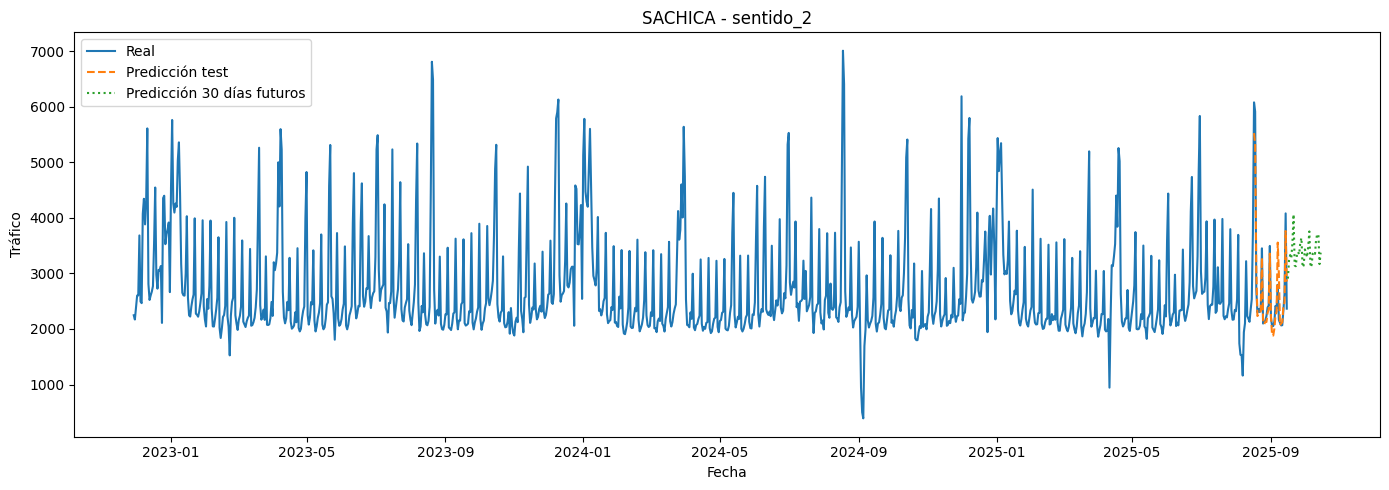

CPU times: total: 19min 3s
Wall time: 1min 18s


In [23]:
%%time

peajes = df_feat['peaje'].unique()
print("Peajes a modelar:", peajes)

all_results = []

models = {}  # dict[(peaje, target)] = modelo
feature_sets = {}  # dict[(peaje, target)] = feature_cols

for peaje in peajes:
    df_p = df_feat[df_feat['peaje'] == peaje].copy()

    for target_col in ['sentido_1', 'sentido_2']:
        if target_col not in df_p.columns:
            continue

        print(f"\n===== Entrenando modelo para {peaje} - {target_col} =====")

        result = train_xgb_with_tuning(df_p, target_col, use_gpu=False)
        if result is None:
            continue

        model, metrics, splits = result
        feature_cols = splits["feature_cols"]

        # Guardar modelo con nombre apropiado
        peaje_slug = slugify(peaje)
        sentido_slug = target_col
        model_name = f"xgb_{peaje_slug}_{sentido_slug}"
        model_path = f"./modelo/{model_name}.joblib"
        #os.makedirs(model_path, exist_ok=True)

        dump(model, model_path)
        print(f"Modelo guardado en: {model_path}")

        models[(peaje, target_col)] = model
        feature_sets[(peaje, target_col)] = feature_cols

        # Construir df_peaje_full (con recorte de ceros) para forecasting
        df_p_trim = trim_zeros_begin_end(df_p, col='total')
        df_p_trim = df_p_trim.sort_values('fecha').reset_index(drop=True)

        # Forecast 30 días futuros
        future_df = forecast_future_days(df_p_trim, model, target_col, feature_cols, horizon=30)

        # DataFrame completo con info de train/val/test/future
        full_df = build_full_results_df(df_p_trim, target_col, splits, future_df, metrics, model_name)

        # Guardar CSV específico por modelo
        csv_name = f"resultados_{peaje_slug}_{sentido_slug}.csv"
        csv_path = f"./modelo/{csv_name}"
        full_df.to_csv(csv_path, index=False)
        print(f"Resultados detallados guardados en: {csv_path}")

        all_results.append(full_df)

        # Graficar resultados para este modelo
        plot_results(full_df, peaje, target_col)

        generate_dashboard_html(
            df_hist=df_p_trim.set_index('fecha'),
            df_future=future_df.set_index('fecha'),
            preds=splits["y_test_pred"],
            idx_test=splits["test"]['fecha'],
            peaje=peaje
        )

## **Bloque 8 – Resumen global de métricas**

In [24]:
if len(all_results) > 0:
    resumen_list = []
    for df_res in all_results:
        row = {
            "modelo": df_res['modelo'].iloc[0],
            "peaje": df_res['peaje'].iloc[0],
            "target": df_res['target'].iloc[0],
            "rmse_train": df_res['rmse_train'].iloc[0],
            "mae_train": df_res['mae_train'].iloc[0],
            "rmse_val": df_res['rmse_val'].iloc[0],
            "mae_val": df_res['mae_val'].iloc[0],
            "rmse_test": df_res['rmse_test'].iloc[0],
            "mae_test": df_res['mae_test'].iloc[0],
            "smape_val": df_res['smape_val'].iloc[0],
            "smape_test": df_res['smape_test'].iloc[0],
            "mase_val": df_res['mase_val'].iloc[0],
            "mase_test": df_res['mase_test'].iloc[0],
        }
        resumen_list.append(row)

    resumen_df = pd.DataFrame(resumen_list)
    resumen_df = resumen_df.sort_values(['peaje', 'target'])

    display(resumen_df)

    resumen_df.to_csv("./modelo/resumen_metricas_modelos.csv", index=False)
    print("Resumen de métricas guardado en ./modelo/resumen_metricas_modelos.csv")

,modelo,peaje,target,rmse_train,mae_train,rmse_val,mae_val,rmse_test,mae_test,smape_val,smape_test,mase_val,mase_test
0,xgb_bicentenario_sentido_1,BICENTENARIO,sentido_1,24.045861,16.726152,169.630009,116.181541,97.132656,74.099327,9.621845,7.063205,0.417648,0.266371
1,xgb_bicentenario_sentido_2,BICENTENARIO,sentido_2,9.519601,7.342737,144.104854,82.699638,76.586960,57.640797,6.871500,5.030452,0.251302,0.175155
2,xgb_casablanca_sentido_1,CASABLANCA,sentido_1,13.172257,9.215143,465.600687,311.635925,368.615399,240.024994,6.129463,4.684867,0.422206,0.325187
3,xgb_casablanca_sentido_2,CASABLANCA,sentido_2,160.380900,115.526093,384.250386,250.101929,401.428562,266.505890,5.828537,4.816279,0.394549,0.420427
4,xgb_cerritos_ii_sentido_1,CERRITOS II,sentido_1,33.269058,25.448433,446.038570,344.763824,463.316425,342.181641,5.134997,5.097860,0.657149,0.652227
5,xgb_cerritos_ii_sentido_2,CERRITOS II,sentido_2,15.637913,10.956628,278.244595,232.342972,268.065771,216.851379,4.330149,4.216628,0.505510,0.471804
6,xgb_la_parada_sentido_2,LA PARADA,sentido_2,408.146803,265.935608,2767.962969,1329.799438,519.699011,381.161224,7.759195,2.231639,0.851951,0.244195
7,xgb_peaje_tunel_la_linea_quindio_sentido_2,PEAJE TUNEL LA LINEA QUINDIO,sentido_2,35.948986,27.512129,438.909052,324.058960,407.113908,300.632202,7.659988,7.514552,0.576830,0.535130
8,xgb_peaje_tunel_la_linea_tolima_sentido_1,PEAJE TUNEL LA LINEA TOLIMA,sentido_1,12.877384,8.903311,373.162038,276.640503,387.069014,309.125000,6.843413,8.134281,0.521595,0.582844
9,xgb_pto_triunfo_sentido_1,PTO. TRIUNFO,sentido_1,51.001175,37.474724,494.354661,281.347046,462.653978,249.046936,22.427242,12.026188,0.650609,0.575916


Resumen de métricas guardado en ./modelo/resumen_metricas_modelos.csv


# **ANÁLISIS DE RESULTADOS**

## **Interpretación de métricas (Rangos y significado)**

Este proyecto utiliza cuatro métricas principales para evaluar el desempeño de los modelos XGBoost: **RMSE**, **MAE**, **SMAPE** y **MASE**.  
A continuación, se presenta una guía clara del significado de cada una, así como rangos de interpretación que permiten determinar si un modelo puede considerarse bueno, aceptable o débil.



## RMSE y MAE (error absoluto)
Estas métricas representan el error en la misma escala del tráfico diario (vehículos).  
Su interpretación depende del rango típico de valores en cada estación.

| Error relativo al nivel de tráfico | Interpretación |
|-----------------------------------|----------------|
| **< 5%** del volumen típico | Excelente |
| **5–10%** | Bueno |
| **10–15%** | Aceptable |
| **> 15%** | Débil / insuficiente |



## SMAPE (error porcentual relativo)
Indica qué porcentaje de error promedio tiene el modelo respecto a los valores reales.

| SMAPE | Calidad del modelo |
|-------|--------------------|
| **0–10%** | Excelente / muy bueno |
| **10–20%** | Aceptable |
| **> 20%** | Débil |



## MASE (comparación frente a naive estacional)
Evalúa si el modelo supera un pronóstico naive basado en el valor de hace 7 días.

| MASE | Interpretación |
|------|----------------|
| **< 1** | Mejor que naive (bueno) |
| **0.3–0.7** | Muy bueno |
| **< 0.3** | Excelente |
| **> 1** | Peor que naive (malo) |



En conjunto, estas métricas permiten analizar tanto la precisión absoluta como la relativa, y comparar modelos de diferentes escalas.


## **Análisis global del desempeño**

A partir de las métricas calculadas para los 13 modelos (8 estaciones × 1 o 2 sentidos), se pueden extraer las siguientes conclusiones generales:



## Precisión relativa (SMAPE)
- **12 de 13 modelos presentan SMAPE < 10%**, lo cual es un resultado **excelente** para series temporales reales de tráfico.
- Indica que la mayor parte de los modelos se alinean bien con los patrones reales.



## Comparación frente al naive (MASE)
- **Todos los modelos tienen MASE < 1**, lo que significa que **ningún modelo es peor que un pronóstico ingenuo** basado en la estacionalidad semanal.
- En muchos casos, los valores están entre 0.2 y 0.6, señal de un buen desempeño relativo.



## Errores absolutos (RMSE / MAE)
- Considerando las magnitudes reales de tráfico en cada estación (desde cientos hasta decenas de miles), los valores reportados se encuentran dentro de rangos lógicos.
- Varias estaciones con alto tráfico presentan RMSE altos en valor absoluto, pero **bajos en términos relativos**.



## Conclusión general
- El sistema completo de modelos muestra un **desempeño sólido, estable y consistente**.
- Solo dos casos presentan desviaciones moderadas, pero ninguno cae en un comportamiento inaceptable.


## **Análisis puntual por estación y sentido**
A continuación se presenta el análisis individual por estación y sentido, incluyendo ahora **RMSE** y **MAE**, que representan la magnitud real de los errores.

---

## BICENTENARIO — sentido 1
- **RMSE_test:** 99.96  
- **MAE_test:** 75.22  
- **SMAPE_test:** 7.03%  
- **MASE_test:** 0.27  
**Interpretación:**  
Errores absolutos bajos respecto al nivel de tráfico (~800–1500 por día).  
**Conclusión:** Excelente desempeño.

---

## BICENTENARIO — sentido 2
- **RMSE_test:** 113.82  
- **MAE_test:** 72.90  
- **SMAPE_test:** 5.71%  
- **MASE_test:** 0.22  
**Interpretación:**  
Error real bajo y error relativo muy bueno.  
**Conclusión:** Excelente modelo.

---

## CASABLANCA — sentido 1
- **RMSE_test:** 382.83  
- **MAE_test:** 236.24  
- **SMAPE_test:** 4.59%  
- **MASE_test:** 0.32  
**Interpretación:**  
Aunque el RMSE parece alto, el tráfico típico es de miles de vehículos.  
**Conclusión:** Muy buen desempeño relativo.

---

## CASABLANCA — sentido 2
- **RMSE_test:** 375.42  
- **MAE_test:** 248.16  
- **SMAPE_test:** 4.50%  
- **MASE_test:** 0.39  
**Interpretación:**  
Errores absolutos razonables y error relativo sobresaliente.  
**Conclusión:** Excelente alineación al comportamiento real.

---

## CERRITOS II — sentido 1
- **RMSE_test:** 458.77  
- **MAE_test:** 352.26  
- **SMAPE_test:** 5.26%  
- **MASE_test:** 0.67  
**Interpretación:**  
Errores absolutos altos pero proporcionales al volumen (9000–11000).  
**Conclusión:** Desempeño bueno/aceptable.

**Posible causa:** Variabilidad y picos fuertes en este sentido.

---

## CERRITOS II — sentido 2
- **RMSE_test:** 274.15  
- **MAE_test:** 223.65  
- **SMAPE_test:** 4.38%  
- **MASE_test:** 0.49  
**Interpretación:**  
Modelo más estable que sentido 1.  
**Conclusión:** Buen desempeño.

---

## LA PARADA — sentido 2
- **RMSE_test:** 513.06  
- **MAE_test:** 371.56  
- **SMAPE_test:** 2.20%  
- **MASE_test:** 0.23  
**Interpretación:**  
Tráfico extremadamente alto (15k–20k). RMSE es pequeño relativo a magnitud.  
**Conclusión:** Uno de los mejores modelos de toda la serie.

---

## TÚNEL LA LÍNEA QUINDÍO — sentido 2
- **RMSE_test:** 422.77  
- **MAE_test:** 304.37  
- **SMAPE_test:** 7.53%  
- **MASE_test:** 0.54  
**Interpretación:**  
Errores absolutos moderados acorde al tráfico (~5000–7000).  
**Conclusión:** Rendimiento razonable.

---

## TÚNEL LA LÍNEA TOLIMA — sentido 1
- **RMSE_test:** 395.65  
- **MAE_test:** 310.43  
- **SMAPE_test:** 8.23%  
- **MASE_test:** 0.58  
**Interpretación:**  
Errores aceptables dentro del rango de la estación.  
**Conclusión:** Buena precisión.

---

## PTO. TRIUNFO — sentido 1
- **RMSE_test:** 467.47  
- **MAE_test:** 256.87  
- **SMAPE_test:** 12.45%  
- **MASE_test:** 0.59  
**Interpretación:**  
Error relativo alto comparado con otras estaciones.  
**Conclusión:** Desempeño moderado.

**Posibles causas:**  
- Alta irregularidad o volatilidad.  
- Picos no capturados por los lags actuales.

---

## PTO. TRIUNFO — sentido 2
- **RMSE_test:** 507.29  
- **MAE_test:** 353.82  
- **SMAPE_test:** 18.12%  
- **MASE_test:** 0.81  
**Interpretación:**  
Modelo con mayor error relativo de todo el conjunto.  
**Conclusión:** Desempeño débil/moderado.

**Posibles causas:**  
- Serie muy ruidosa o no estacionaria.  
- Cambios operativos no reflejados en los datos.  
- Patrones menos predecibles entre días.

---

## SÁCHICA — sentido 1
- **RMSE_test:** 295.31  
- **MAE_test:** 194.59  
- **SMAPE_test:** 7.84%  
- **MASE_test:** 0.34  
**Interpretación:**  
Buen rendimiento considerando tráfico moderado.  
**Conclusión:** Modelo sólido.

---

## SÁCHICA — sentido 2
- **RMSE_test:** 267.61  
- **MAE_test:** 181.10  
- **SMAPE_test:** 6.29%  
- **MASE_test:** 0.34  
**Interpretación:**  
Errores consistentes y estables.  
**Conclusión:** Excelente desempeño relativo.


## **Conclusión final del desempeño**

Con base en los resultados obtenidos para los 13 modelos evaluados se concluye lo siguiente:

---

## Resumen general de precisión
- **12 de 13 modelos tienen SMAPE < 10%**, lo cual constituye un desempeño excelente en predicción de tráfico.
- Los valores de **MASE < 1 en todos los casos** confirman que **todos los modelos superan el naive estacional**.
- Los valores de **RMSE y MAE** se encuentran en rangos coherentes con el nivel de tráfico de cada estación.

---

## Modelos con mejores métricas
Presentan combinación de:
- RMSE y MAE bajos en escala relativa,  
- SMAPE < 6%,  
- MASE entre 0.2 y 0.4.

Incluye:
- **La Parada (sentido 2)**  
- **Bicentenario (ambos)**  
- **Casablanca (ambos)**  
- **Sachica (ambos)**  
- **Cerritos II (sentido 2)**  

Estos modelos muestran comportamiento muy estable y adecuada “memoria” temporal.

---

## Modelos con desempeño aceptable
- **Túnel La Línea (Tolima y Quindío)**  
- **Cerritos II sentido 1**

Tienen RMSE y MAE moderados, pero SMAPE < 10%.  
Su precisión es buena, aunque no sobresaliente.

---

## Modelos con desempeño moderado/debil
- **PTO. TRIUNFO sentido 1**  
  - SMAPE_test ~12.5%  
  - MASE_test ~0.59  
  - RMSE y MAE relativamente altos para la escala  

- **PTO. TRIUNFO sentido 2**  
  - SMAPE_test ~18%  
  - MASE_test ~0.81  
  - RMSE_test > 500  

Estos valores indican **desviación porcentual alta** comparada con otras estaciones.

### Posibles razones (basadas solo en métricas):
- Series altamente ruidosas o con picos fuertes difíciles de capturar.  
- Patrones de estacionalidad débiles.  
- Cambios operacionales en el peaje.  
- Valores atípicos pronunciados.

---

## Conclusión final
El sistema completo de modelos XGBoost demuestra un **desempeño robusto, consistente y superior al naive estacional**, con excelentes resultados relativos en la mayoría de estaciones.  
Solo dos modelos presentan desviaciones moderadas, explicables por el comportamiento irregular de esas series.  

En términos estadísticos y operativos, se puede considerar que el conjunto de modelos proporciona **pronósticos confiables y adecuados para aplicaciones prácticas de predicción de tráfico.**


## **Bloque A – Cargar resultados detallados y construir métricas extendidas**

In [25]:
import glob
import numpy as np
import pandas as pd

files = glob.glob("./modelo/resultados_*.csv")
rows = []

for path in files:
    df_mod = pd.read_csv(path)

    modelo = df_mod.loc[0, 'modelo']
    peaje = df_mod.loc[0, 'peaje']
    target = df_mod.loc[0, 'target']

    rmse_test = df_mod.loc[0, 'rmse_test']
    mae_test  = df_mod.loc[0, 'mae_test']

    # Serie real en test
    mask_test = df_mod['set'] == 'test'
    y_test = df_mod.loc[mask_test, 'y_real'].dropna()

    if len(y_test) > 0:
        mean_y_test = y_test.abs().mean()
        range_y_test = y_test.max() - y_test.min()
    else:
        mean_y_test = np.nan
        range_y_test = np.nan

    rmse_pct_mean = rmse_test / mean_y_test * 100 if mean_y_test else np.nan
    mae_pct_mean  = mae_test / mean_y_test * 100 if mean_y_test else np.nan
    rmse_pct_range = rmse_test / range_y_test * 100 if range_y_test else np.nan

    rows.append({
        "modelo": modelo,
        "peaje": peaje,
        "target": target,
        "rmse_pct_mean": rmse_pct_mean,
        "mae_pct_mean": mae_pct_mean,
        "rmse_pct_range": rmse_pct_range
    })

df_ext = pd.DataFrame(rows).sort_values(["peaje", "target"]).reset_index(drop=True)
df_ext

,modelo,peaje,target,rmse_pct_mean,mae_pct_mean,rmse_pct_range
0,xgb_bicentenario_sentido_1,BICENTENARIO,sentido_1,9.270742,7.072346,17.407286
1,xgb_bicentenario_sentido_2,BICENTENARIO,sentido_2,6.620588,4.982780,3.217940
2,xgb_casablanca_sentido_1,CASABLANCA,sentido_1,7.418749,4.830740,19.228764
3,xgb_casablanca_sentido_2,CASABLANCA,sentido_2,8.031141,5.331824,5.921649
4,xgb_cerritos_ii_sentido_1,CERRITOS II,sentido_1,6.899381,5.095527,18.972827
5,xgb_cerritos_ii_sentido_2,CERRITOS II,sentido_2,5.220366,4.223006,20.975412
6,xgb_la_parada_sentido_2,LA PARADA,sentido_2,3.027443,2.220408,6.760752
7,xgb_peaje_tunel_la_linea_quindio_sentido_2,PEAJE TUNEL LA LINEA QUINDIO,sentido_2,9.949750,7.347367,17.206843
8,xgb_peaje_tunel_la_linea_tolima_sentido_1,PEAJE TUNEL LA LINEA TOLIMA,sentido_1,9.968384,7.961052,21.551727
9,xgb_pto_triunfo_sentido_1,PTO. TRIUNFO,sentido_1,21.325046,11.479286,15.667253


## **Bloque B – Gráfico: MAE y RMSE Normalizados por Estación y Sentido - Error Relativo en % del Tráfico Promedio de la serie (todas las estaciones)**

Archivos encontrados: ['./modelo\\resultados_bicentenario_sentido_1.csv', './modelo\\resultados_bicentenario_sentido_2.csv', './modelo\\resultados_casablanca_sentido_1.csv', './modelo\\resultados_casablanca_sentido_2.csv', './modelo\\resultados_cerritos_ii_sentido_1.csv', './modelo\\resultados_cerritos_ii_sentido_2.csv', './modelo\\resultados_la_parada_sentido_2.csv', './modelo\\resultados_peaje_tunel_la_linea_quindio_sentido_2.csv', './modelo\\resultados_peaje_tunel_la_linea_tolima_sentido_1.csv', './modelo\\resultados_pto_triunfo_sentido_1.csv', './modelo\\resultados_pto_triunfo_sentido_2.csv', './modelo\\resultados_sachica_sentido_1.csv', './modelo\\resultados_sachica_sentido_2.csv']


,modelo,peaje,target,mae_norm_pct,rmse_norm_pct
0,xgb_bicentenario_sentido_1,BICENTENARIO,sentido_1,7.072346,9.270742
1,xgb_bicentenario_sentido_2,BICENTENARIO,sentido_2,4.982780,6.620588
2,xgb_casablanca_sentido_1,CASABLANCA,sentido_1,4.830740,7.418749
3,xgb_casablanca_sentido_2,CASABLANCA,sentido_2,5.331824,8.031141
4,xgb_cerritos_ii_sentido_1,CERRITOS II,sentido_1,5.095527,6.899381
5,xgb_cerritos_ii_sentido_2,CERRITOS II,sentido_2,4.223006,5.220366
6,xgb_la_parada_sentido_2,LA PARADA,sentido_2,2.220408,3.027443
7,xgb_peaje_tunel_la_linea_quindio_sentido_2,PEAJE TUNEL LA LINEA QUINDIO,sentido_2,7.347367,9.949750
8,xgb_peaje_tunel_la_linea_tolima_sentido_1,PEAJE TUNEL LA LINEA TOLIMA,sentido_1,7.961052,9.968384
9,xgb_pto_triunfo_sentido_1,PTO. TRIUNFO,sentido_1,11.479286,21.325046


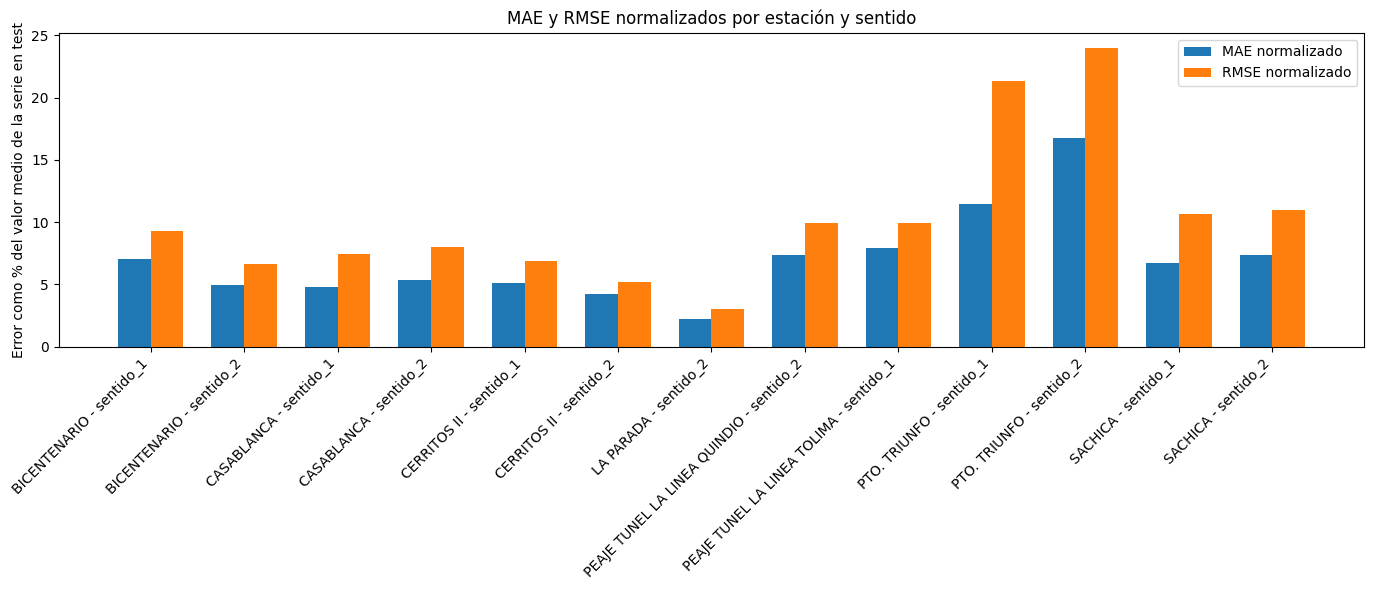

In [26]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar resultados_*.csv y construir tabla con métricas + escala de cada serie
files = glob.glob("./modelo/resultados_*.csv")
print("Archivos encontrados:", files)

rows = []

for path in files:
    df_mod = pd.read_csv(path)

    modelo = df_mod.loc[0, 'modelo']
    peaje = df_mod.loc[0, 'peaje']
    target = df_mod.loc[0, 'target']

    mae_test = df_mod.loc[0, 'mae_test']
    rmse_test = df_mod.loc[0, 'rmse_test']

    # Serie real de test para tener la escala
    mask_test = df_mod['set'] == 'test'
    y_test = df_mod.loc[mask_test, 'y_real'].dropna()

    if len(y_test) == 0:
        continue

    mean_y_test = y_test.abs().mean()

    rows.append({
        "modelo": modelo,
        "peaje": peaje,
        "target": target,
        "mae_test": mae_test,
        "rmse_test": rmse_test,
        "mean_y_test": mean_y_test,
    })

df_ext = pd.DataFrame(rows)

# 2. Ordenar y crear etiqueta "peaje - sentido"
df_ext = df_ext.sort_values(["peaje", "target"]).reset_index(drop=True)
df_ext["label"] = df_ext["peaje"] + " - " + df_ext["target"]

# 3. Normalizar MAE y RMSE por el valor medio de la serie en test (en %)
df_ext["mae_norm_pct"] = df_ext["mae_test"] / df_ext["mean_y_test"] * 100
df_ext["rmse_norm_pct"] = df_ext["rmse_test"] / df_ext["mean_y_test"] * 100

display(df_ext[["modelo", "peaje", "target", "mae_norm_pct", "rmse_norm_pct"]])

# 4. Gráfico conjunto MAE y RMSE normalizados
x = np.arange(len(df_ext))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))

ax.bar(x - width/2, df_ext["mae_norm_pct"], width, label="MAE normalizado")
ax.bar(x + width/2, df_ext["rmse_norm_pct"], width, label="RMSE normalizado")

ax.set_xticks(x)
ax.set_xticklabels(df_ext["label"], rotation=45, ha="right")
ax.set_ylabel("Error como % del valor medio de la serie en test")
ax.set_title("MAE y RMSE normalizados por estación y sentido")
ax.legend()
plt.tight_layout()
plt.show()

## **Bloque C – Gráfico: SMAPE de test por modelo (todas las estaciones en una sola figura)**

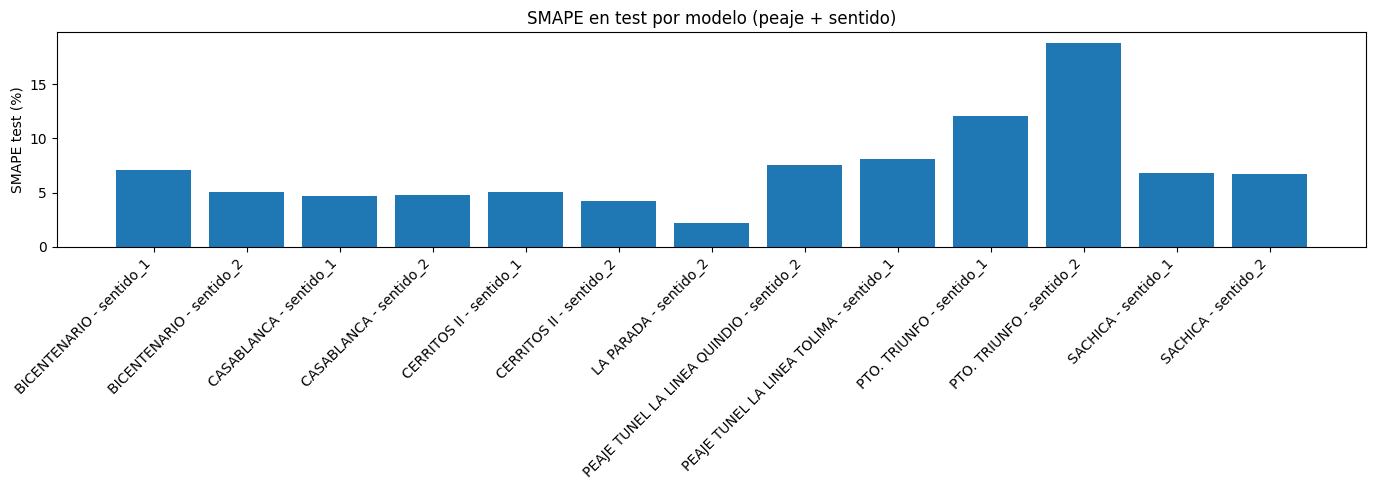

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el resumen que ya generaste con todas las métricas
resumen_path = "./modelo/resumen_metricas_modelos.csv"
df_res = pd.read_csv(resumen_path)

# Etiqueta peaje - sentido
df_res["label"] = df_res["peaje"] + " - " + df_res["target"]

plt.figure(figsize=(14, 5))
plt.xticks(rotation=45, ha='right')

plt.bar(df_res['label'], df_res['smape_test'])
plt.ylabel("SMAPE test (%)")
plt.title("SMAPE en test por modelo (peaje + sentido)")
plt.tight_layout()
plt.show()

## **Bloque D – Gráfico: MASE en test por modelo (comparación con naive estacional)**

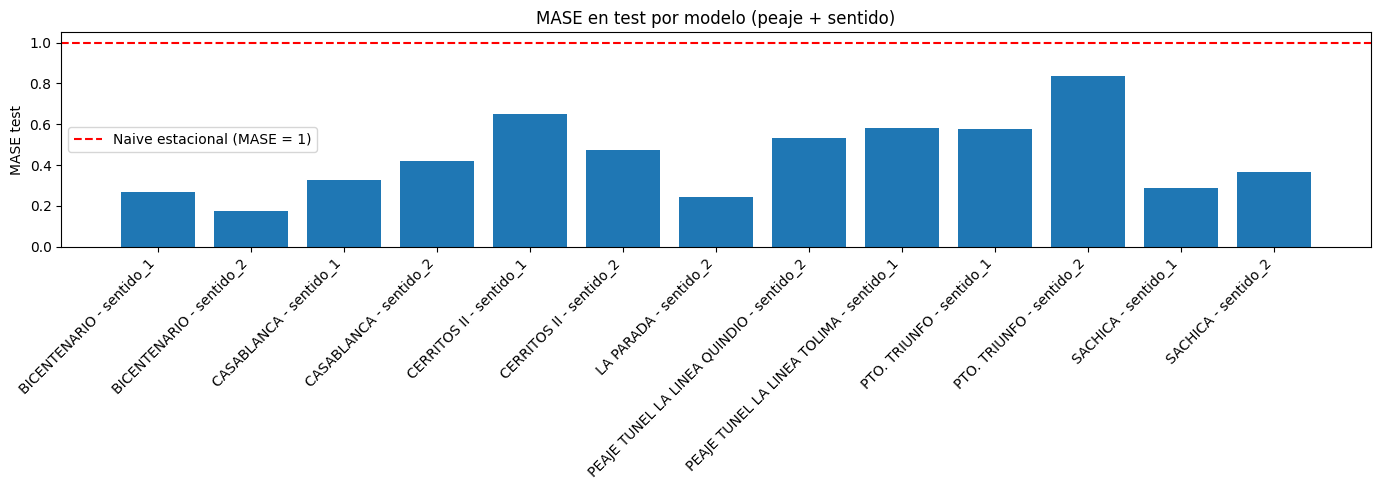

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el resumen con todas las métricas
resumen_path = "./modelo/resumen_metricas_modelos.csv"
df_res = pd.read_csv(resumen_path)

# Etiqueta peaje - sentido
df_res["label"] = df_res["peaje"] + " - " + df_res["target"]

plt.figure(figsize=(14, 5))
plt.xticks(rotation=45, ha='right')

plt.bar(df_res['label'], df_res['mase_test'])
plt.axhline(1.0, color='red', linestyle='--', label='Naive estacional (MASE = 1)')

plt.ylabel("MASE test")
plt.title("MASE en test por modelo (peaje + sentido)")
plt.legend()
plt.tight_layout()
plt.show()

# **DESCARGA ARCHIVOS**

In [ ]:
!zip -r /content/resultados_modelos.zip /content && echo "ZIP listo en /content/resultados_modelos.zip"

updating: content/ (stored 0%)
updating: content/.config/ (stored 0%)
updating: content/.config/.last_survey_prompt.yaml (stored 0%)
updating: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
updating: content/.config/active_config (stored 0%)
updating: content/.config/.last_opt_in_prompt.yaml (stored 0%)
updating: content/.config/configurations/ (stored 0%)
updating: content/.config/configurations/config_default (deflated 15%)
updating: content/.config/default_configs.db (deflated 98%)
updating: content/.config/logs/ (stored 0%)
updating: content/.config/logs/2025.11.20/ (stored 0%)
updating: content/.config/logs/2025.11.20/14.30.45.231815.log (deflated 57%)
updating: content/.config/logs/2025.11.20/14.30.45.937471.log (deflated 56%)
updating: content/.config/logs/2025.11.20/14.30.36.623222.log (deflated 58%)
updating: content/.config/logs/2025.11.20/14.30.35.382199.log (deflated 87%)
updating: content/.config/logs/2025.11.20/14.30.04.28520